In [1]:
import torch

In [2]:

import numpy as np
import torchvision
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
#download dataset, but i already have it downloaded
dataset = MNIST(root='data/', download=True)
dataset = MNIST(root='data/', train=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:

def split_indices(n, val_pct):
    pct_gone = int(n*val_pct)
    print(pct_gone)
    idxs = np.random.permutation(n)
    #so from 12,000 images to the end - we set the training dataset to those random permutations
    return idxs[pct_gone:], idxs[:pct_gone]

In [5]:
train_indices, val_indices = split_indices(len(dataset), 0.2)

12000


In [6]:
#we will randomize the position of the data, in order to lessen the biases
#we will create batches out of the indices that are specified below
train_sampler = SubsetRandomSampler(train_indices)
#when we do 10 batches, or 4800 images per batch - it kinda sucks
train_loader = DataLoader(dataset, 100, sampler=train_sampler)

In [7]:
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, 100, sampler=val_sampler)

In [12]:
#this has one layer so far, imma create two - the layers will be in - hidden/2 hidden /2 - hidden - hidden - out

#layers have specific weights and biases that are optimized whenever the data is passed through the linput fields whenever we optimize them with opt.step()
#784 - 16 - 16 - 10
#weights and the biases are better
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        hidden_quarter = int(hidden_size/4)
        hidden_half = int(hidden_size/2)
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_half)
        self.linear3 = nn.Linear(hidden_half, hidden_quarter)
        self.linear4 = nn.Linear(hidden_quarter, out_size)
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out=self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out


In [14]:
input_size = 28**2
hidden_size = 64
num_classes = 10

model = MnistModel(input_size, hidden_size, num_classes)

for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([10, 16])
torch.Size([10])


In [15]:
for img, lbl in train_loader:
    out = model(img)
    loss = F.cross_entropy(out, lbl)
    print(loss.item())
    break

2.2697527408599854


In [16]:
#use the gpu if cuda is available
def def_dev():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')


In [17]:
device = def_dev()

In [18]:
device

device(type='cuda')

In [19]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    # print(type (data))
    return data.to(device, non_blocking = True)


In [20]:
#make sure that the images get ported over to using the gpu
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [21]:
#__iter__ means that when you iterate through this will be the response and __len__ means when len() is called
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            #pauses the function - function but remembering the previous value and iteration, so that the next iteration will yield a different item
            # kinda like you are appending to a list while iterating - but there is no list and there is no appending?
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [22]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

In [23]:
len(valid_dl)

120

In [24]:
for xb, yb in valid_dl:
    #as you can see it has now put a lot of stuff on the GPU rather than most of it being on the cpu
    print(xb.device)
    print(yb)

cuda:0
tensor([4, 6, 6, 9, 4, 1, 6, 3, 8, 6, 5, 3, 4, 2, 9, 1, 8, 9, 2, 2, 3, 8, 2, 9,
        1, 5, 6, 7, 5, 6, 5, 9, 9, 5, 7, 6, 9, 3, 0, 8, 4, 4, 1, 6, 3, 0, 1, 5,
        2, 6, 4, 6, 0, 0, 8, 0, 7, 5, 0, 1, 7, 1, 1, 2, 6, 6, 8, 0, 3, 9, 5, 3,
        5, 8, 4, 7, 9, 9, 6, 8, 3, 5, 0, 3, 9, 9, 1, 6, 2, 2, 6, 8, 9, 6, 7, 9,
        4, 4, 9, 9], device='cuda:0')
cuda:0
tensor([2, 9, 2, 0, 7, 1, 3, 0, 7, 5, 5, 6, 9, 6, 7, 4, 3, 8, 1, 2, 0, 1, 2, 9,
        0, 5, 5, 7, 8, 4, 1, 6, 9, 1, 3, 7, 5, 6, 1, 3, 7, 3, 4, 2, 3, 0, 1, 1,
        7, 1, 4, 5, 4, 0, 6, 8, 6, 0, 2, 7, 1, 2, 5, 8, 2, 6, 4, 0, 3, 1, 9, 1,
        8, 4, 0, 8, 8, 5, 9, 8, 0, 4, 4, 5, 8, 2, 3, 1, 6, 9, 1, 3, 2, 6, 3, 7,
        8, 2, 5, 9], device='cuda:0')
cuda:0
tensor([7, 6, 2, 3, 8, 4, 2, 2, 0, 9, 7, 4, 0, 8, 9, 6, 7, 3, 9, 1, 3, 7, 5, 3,
        0, 7, 5, 8, 4, 8, 6, 9, 3, 0, 2, 1, 1, 5, 8, 6, 7, 5, 0, 9, 5, 3, 1, 6,
        2, 6, 1, 1, 0, 2, 8, 2, 6, 3, 2, 3, 7, 6, 3, 9, 2, 3, 6, 6, 9, 0, 4, 6,
        7, 3, 0, 1, 9, 

In [25]:
#Training the model
def loss_batch(model, loss_fn, xb, yb, opt):
    out = model(xb)
    loss = loss_fn(out, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

In [26]:
def fit(epochs, lr, model, loss_fn, train_dl):
    losses, metrics = [], []
    opt = torch.optim.SGD(model.parameters(), lr)
    for epoch in range (epochs):
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)

In [29]:
model = MnistModel(input_size, hidden_size=32, out_size = num_classes)
to_device(model, device)
fit(5, 0.5, model, F.cross_entropy, train_dl)
fit(5, 0.1, model, F.cross_entropy, train_dl)
fit(5, 0.05, model, F.cross_entropy, train_dl)
fit(5, 0.024, model, F.cross_entropy, train_dl)

In [70]:
to_device(model, device)
acc_arr = []
for xb, yb in valid_dl:
    out = model(xb)
    loss = F.cross_entropy(out, yb)
    probs, preds = (torch.max(out, dim=1))
    prediction = (preds[0].item())
    correct_answer = (yb[0].item())
    acc_arr.append(int(prediction == correct_answer))
    

#it seems that adding the extra layer didn't really do anything but it seems that it went up a little bit atleast
#WOW! when i just added one more layer the accuracy went up to 98%!
avg_acc = (sum(acc_arr)/len(acc_arr))

this is the prediction the model generated - with 0.9416666666666667 percent accuracy
7


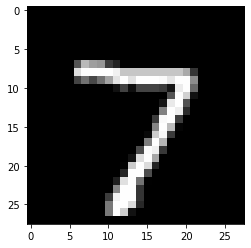

In [71]:
#put the model back on the cpu so i can predict some images. Always can put it back on the gpu later
to_device(model, torch.device("cpu"))
#this is the first batch of the image that i am passing into the thing
img, lbl = test_dataset[0]

plt.imshow(img[0], cmap='gray')
out = model(img)

probs, preds = (torch.max(out, dim=1))
print("this is the prediction the model generated - with {} percent accuracy".format(avg_acc))
print(preds.item())